In [1]:
import sys
import os
from glob import glob

sys.path.insert(0, "..")
import RRE_utils as ut
from multilayer_convnet import convnet_variables
try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ModuleNotFoundError:
    import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
MODEL_DIR = "/lustre/lrspec/users/2649/models/FortinoRRE"
R = [738, 100, 24, 10]

In [3]:
Ytst_arr = []
Ptst_arr = []

for i in range(len(R)):
    dataset_dir = os.path.join(MODEL_DIR, str(R[i]), "training_set")

    Xtst = np.load(
        os.path.join(dataset_dir, "testImages.npy"))
    Ytst = np.load(
        os.path.join(dataset_dir, "testLabels.npy"))
    classes = np.load(
        os.path.join(dataset_dir, "typeNamesList.npy"))

    tf.reset_default_graph()
    nw = Xtst.shape[1]
    nBins = classes.shape[0]
    imWidthReduc = 8
    imWidth = 32  # Image size and width

    x, y_, keep_prob, y_conv, W, b = convnet_variables(
        imWidth, imWidthReduc, nw, nBins)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        index_files = glob(os.path.join(MODEL_DIR, str(R[i]), "*.index"))
        latest_ckpt = max(index_files, key=os.path.getctime)
        saver = tf.train.Saver()
        saver.restore(sess, latest_ckpt.split(".index")[0])

        Ptst = y_conv.eval(feed_dict={x: Xtst, keep_prob: 1.0})

    Ptst = np.argmax(Ptst, axis=1)

    Ytst = ut.agetype_to_subtype(Ytst, classes)
    Ptst = ut.agetype_to_subtype(Ptst, classes)

    Ytst_arr.append(Ytst)
    Ptst_arr.append(Ptst)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/models/FortinoRRE/738/tensorflow_model.ckpt


2022-11-09 22:28:07.546247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/shared/slurm/lib:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/
2022-11-09 22:28:07.546828: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 22:28:07.546859: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r1n10): /proc/driver/nvidia/version does not exist
2022-11-09 22:28:07.549932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 22:28:07.587715:

INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/models/FortinoRRE/100/tensorflow_model.ckpt
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/models/FortinoRRE/24/tensorflow_model.ckpt
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/models/FortinoRRE/10/tensorflow_model.ckpt


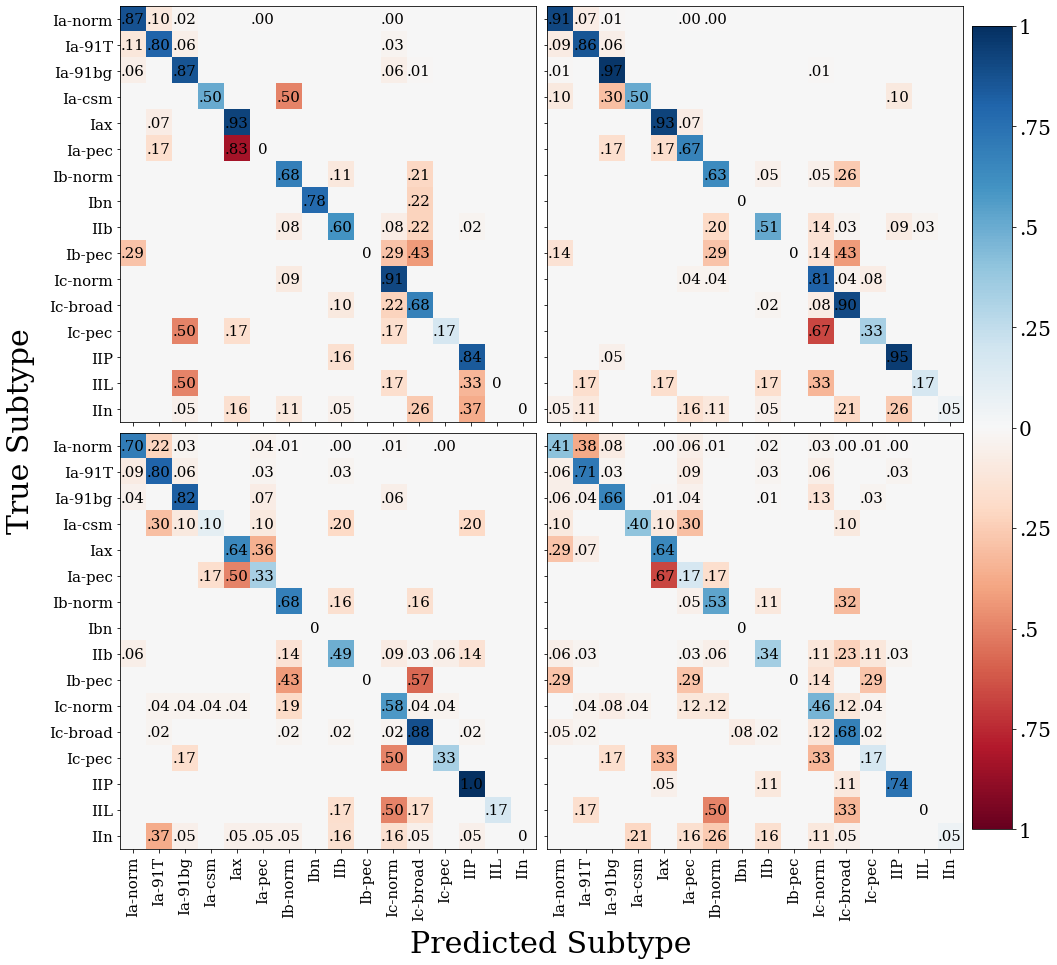

In [4]:
plt.rcParams["font.family"] = "serif"
SNtypes_int = ut.SNtypes_int[:-1]
SNtypes_str = ut.SNtypes_str[:-1]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 15.5))
fig.subplots_adjust(hspace=0.025, wspace=0.025)

for i in range(len(R)):
    ax = axes.flatten()[i]

    # Plotting
    cm = confusion_matrix(
        Ytst_arr[i], Ptst_arr[i],
        normalize="true", labels=SNtypes_int)
    diag = np.diag_indices(cm.shape[0])
    cm[diag] *= -1
    cm *= -1

    im = ax.imshow(
        cm,
        interpolation="nearest", cmap="RdBu",
        vmin=-1, vmax=1)

    for i, true_type in enumerate(cm):
        for j, pred_type in enumerate(cm):
            val = np.round(np.abs(cm[i, j]), 2)

            if cm[i, j] == 0:
                if i != j:
                    continue
                else:
                    val = "0"

            elif cm[i, j] == 1:
                val = "1.0"

            else:
                val = f"{val:.2f}"[1:]

            ax.annotate(
                val, xy=(j, i),
                ha="center", va="center",
                fontsize=15)

    ax.set_xticks(
        SNtypes_int,
        SNtypes_str,
        fontsize=15,
        rotation=90)
    ax.set_yticks(
        SNtypes_int,
        SNtypes_str,
        fontsize=15)

fig.text(
    0.5, 0.04,
    "Predicted Subtype", fontsize=30,
    ha="center", va="center")
fig.text(
    0.04, 0.5,
    "True Subtype", fontsize=30,
    ha="center", va="center",
    rotation=90)

cbar = fig.colorbar(
    im, ax=axes.flatten(), location="right", fraction=.045, pad=0.01)

cbar.set_ticks(
    ticks=[-1, -.75, -.5, -.25, 0, .25, .5, .75, 1],
    labels=["1", ".75", ".5", ".25", "0", ".25", ".5", ".75", "1"],
    fontsize=20)

fig.savefig("cm.pdf", bbox_inches="tight", pad_inches=0.1)
fig.show()

In [5]:
R

[738, 100, 24, 10]